In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# FUNCTIONS

### Thermodynamic functions

#### Heat capacity fitting equation

Taken from the Origin DSC manual


$$C_{p}(T) = B_{0} + B_{1}T + \Big [ \frac{K(T)\Delta C_{p}}{1 + K(T)} + \frac{K(T)\Delta H(T)^{2}}{(1 + K(T))^{2}RT^{2}}\Big ]$$

In [3]:
R = 0.008314

def dH_v_T(T,dCp,dH,Tm):
    
    return dCp*(T - Tm) + dH

def dS_v_T(T,dCp,dH,Tm):
    
    return dCp*np.log(T/Tm) + dH/Tm

def dG_v_T(T,dCp,dH,Tm):

    return dH_v_T(T,dCp,dH,Tm) - T*dS_v_T(T,dCp,dH,Tm)

def K_v_T(T,dCp,dH,Tm):
    
    return np.exp(-dG_v_T(T,dCp,dH,Tm)/(R*T))

def Cp_v_T(T,dCp,dH,Tm,B0=0,B1=0):
    
    KT = K_v_T(T,dCp,dH,Tm)
    HT = dH_v_T(T,dCp,dH,Tm)
    
    a = KT*dCp/(1 + KT)
    b = KT*(HT**2)/((1 + KT)**2 * R * (T**2))
    
    return B0 + B1*T + a + b

def fx_v_T(T,dCp,dH,Tm):
    
    dG = dG_v_T(T,dCp,dH,Tm)
    
    weight = np.exp(-dG/(R*T))
    
    return 1/(1 + weight)

### Experimental simulation functions

In [4]:
def baseline_v_T(T,T_mid,spread,offset):
    
    return offset - spread*(T - T_mid)**2   

def noise_v_T(T,baseline_noise):
    
    return np.random.normal(scale=baseline_noise,size=len(T))

def generate_experiment(dCp,dH,Tm,
                        T_min=300,T_max=373,T_step=0.5,
                        baseline_T_mid=330,
                        baseline_spread=0.001,
                        baseline_offset=10,
                        baseline_noise=0.25):
    
    T = np.arange(T_min,T_max+T_step,T_step)
    baseline = baseline_v_T(T,baseline_T_mid,baseline_spread,baseline_offset) 
    buffer = baseline + noise_v_T(T,baseline_noise)
    protein = baseline + noise_v_T(T,baseline_noise) + Cp_v_T(T,dCp,dH,Tm)
    
    out = pd.DataFrame({"temperature":T,
                        "buffer":buffer,
                        "protein":protein})
    
    return out
    

# GENERATE DATA FOR LAB

### Construct "experimental" datasets

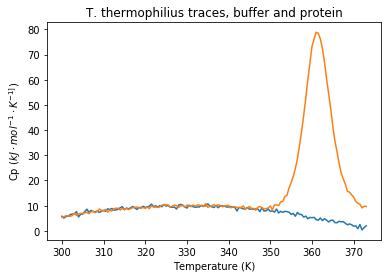

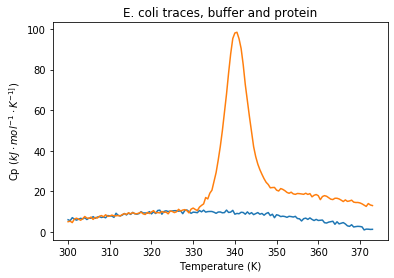

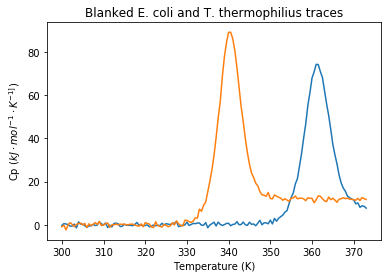

In [5]:
tt_dCp = 1.91*4.184
tt_dH = 131*4.184
tt_Tm = 361

ec_dCp = 2.89*4.184
ec_dH = 135*4.184
ec_Tm = 340

tt = generate_experiment(tt_dCp,tt_dH,tt_Tm,baseline_spread=0.005,baseline_noise=0.5)
ec = generate_experiment(ec_dCp,ec_dH,ec_Tm,baseline_spread=0.005,baseline_noise=0.5)

plt.title("T. thermophilius traces, buffer and protein")
plt.plot(tt.temperature,tt.buffer)
plt.plot(tt.temperature,tt.protein)
plt.xlabel("Temperature (K)")
plt.ylabel("Cp ($kJ \cdot mol^{-1} \cdot K^{-1]}$)")
plt.show()

plt.title("E. coli traces, buffer and protein")
plt.plot(ec.temperature,ec.buffer)
plt.plot(ec.temperature,ec.protein)
plt.xlabel("Temperature (K)")
plt.ylabel("Cp ($kJ \cdot mol^{-1} \cdot K^{-1]}$)")
plt.show()

plt.title("Blanked E. coli and T. thermophilius traces")
plt.plot(tt.temperature,tt.protein-tt.buffer)
plt.plot(ec.temperature,ec.protein-ec.buffer)
plt.xlabel("Temperature (K)")
plt.ylabel("Cp ($kJ \cdot mol^{-1} \cdot K^{-1]}$)")
plt.show()

# Write out csv files
tt.to_csv("tt.csv")
ec.to_csv("ec.csv")



# LAB KEY AND TESTING

## 1. Extract thermo from data

### Tm

In [6]:
my_ec = pd.read_csv("ec.csv")
blanked = ec.protein - ec.buffer
Tm = float(my_ec.temperature[blanked == np.max(blanked)])
print("extracted:",Tm, "input:",ec_Tm)

extracted: 340.0 input: 340


### dCp

extracted: 12.042781501736105 input: 12.09176


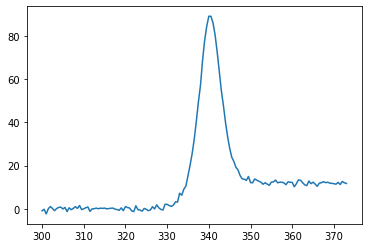

In [7]:
plt.plot(my_ec.temperature,blanked)
num_points = len(my_ec.temperature)

ten_pct = int(round(num_points*0.1))
folded_Cp = np.mean(blanked[:ten_pct])
unfolded_Cp = np.mean(blanked[-ten_pct:])
dCp = unfolded_Cp - folded_Cp 
print("extracted:",dCp, "input:",ec_dCp)

In [8]:
T_step = my_ec.temperature.iloc[1] - my_ec.temperature.iloc[0]

low_mask = my_ec.temperature < Tm
high_mask = my_ec.temperature >= Tm

below_tm = np.sum((blanked[low_mask] - folded_Cp)*T_step)
above_tm = np.sum((blanked[high_mask] - unfolded_Cp)*T_step)
dH = below_tm + above_tm
print("extracted:",dH,"input:",ec_dH)

extracted: 572.4043606690125 input: 564.84


### dS

In [9]:
print("extracted:",dH/Tm,"input:",ec_dH/ec_Tm)

extracted: 1.6835422372618014 input: 1.6612941176470588


## 2. Plot dG(T)

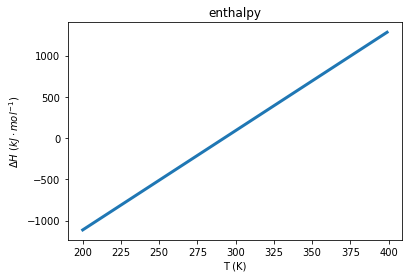

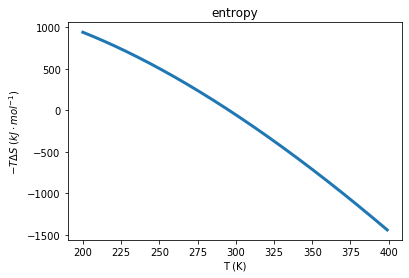

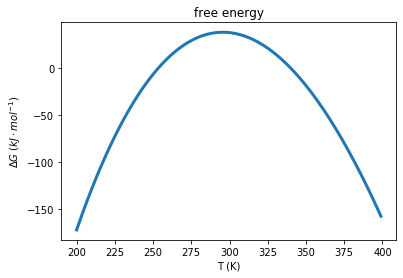

In [11]:
new_T_range = np.arange(200,400)

plt.plot(new_T_range,dH_v_T(new_T_range,dCp,dH,Tm),label="dH",linewidth=3)
plt.title("enthalpy")
plt.xlabel("T (K)")
plt.ylabel("$\Delta H$ ($kJ \cdot mol^{-1}}$)")
plt.show()

plt.plot(new_T_range,-new_T_range*dS_v_T(new_T_range,dCp,dH,Tm),label="-TdS",linewidth=3)
plt.title("entropy")
plt.xlabel("T (K)")
plt.ylabel("$-T\Delta S$ ($kJ \cdot mol^{-1}}$)")
plt.show()

plt.plot(new_T_range,dG_v_T(new_T_range,dCp,dH,Tm),label="dG",linewidth=3)
plt.title("free energy")
plt.xlabel("T (K)")
plt.ylabel("$\Delta G$ ($kJ \cdot mol^{-1}}$)")
plt.show()


#### A. What do you observe? 

Starts with low stability, peaks, then drops to high stability.  Unfolds both at high and low temperatures. 

#### B. Justify shape using shapes. 

-TdS follows a curve; dH is a line.  At low temperature, dH is destabilizing and TdS is stabilizing.  TdS, however, is curving, so the slope of the dH line wins and the folded state becomes more stable with increasing temperature.  At high temperature, even though enthalpy strongly favors folding, entropy even more strongly disfavors folding.  Because entropy is a nonlinear function of Tln(T), entropy wins over the linear function of T that is enthalpy. 

#### C. Justify shape in molecular terms

At low T, hydrophobic effect is strongest.  At high T, hydrophobic effect is weakest. This all comes down to disorder of water:

+ Hydrophobic surfaces can induce much higher degrees of ordering to water when thermal motion is less.
+ Entropy scales inversely with temperature.  the same amount of heat will have a greater effect on entropy at low temperature vs. high temperature ($dS = \frac{\delta q}{T}$).

Enthalpy exhibits the opposite trend.  
+ At low T, ordered water strongly competes for hbonds bonds with protein donors and acceptors. This means enthalpy favors the unfolded state more than a high temperature.  
+ At high temperature, enthalpy favors a protein forming self-self bonds rather than interactions with highly dynamic water molecules. 

At low temperature, entropy (hydrophobic effect) drives folding.  At high temperature, enthalpy drives folding.  At extreme temperature, unfolded state is favored. 

## 3. Plot of fraction folded

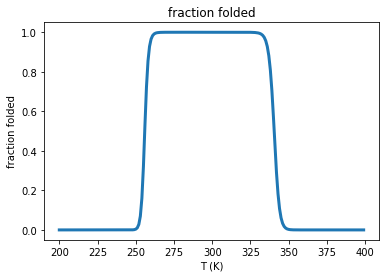

In [83]:
plt.plot(new_T_range,fx_v_T(new_T_range,dCp,dH,Tm),label="fx",linewidth=3)
plt.title("fraction folded")
plt.xlabel("T (K)")
plt.ylabel("fraction folded")
plt.show()

Protein unfolds at both high and low temperatures.  This is because it becomes so enthalpically unfavorable to fold the protein that the hydrophobic effect is overwhelmed.

## 4. Analyze tt

### Tm

In [84]:
my_tt = pd.read_csv("tt.csv")
blanked = tt.protein - tt.buffer
Tm = float(my_tt.temperature[blanked == np.max(blanked)])
print("extracted:",Tm, "input:",tt_Tm)

extracted: 361.5 input: 361


### dCp

extracted: 8.381985623255199 input: 7.99144


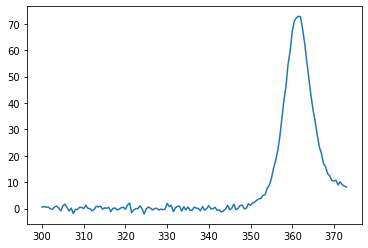

In [85]:
plt.plot(my_tt.temperature,blanked)
num_points = len(my_tt.temperature)

two_pct = int(round(num_points*0.03))
folded_Cp = np.mean(blanked[:two_pct])
unfolded_Cp = np.mean(blanked[-two_pct:])
dCp = unfolded_Cp - folded_Cp 
print("extracted:",dCp, "input:",tt_dCp)

In [86]:
T_step = my_tt.temperature.iloc[1] - my_tt.temperature.iloc[0]

low_mask = my_tt.temperature < Tm
high_mask = my_tt.temperature >= Tm

below_tm = np.sum((blanked[low_mask] - folded_Cp)*T_step)
above_tm = np.sum((blanked[high_mask] - unfolded_Cp)*T_step)
dH = below_tm + above_tm
print("extracted:",dH,"input:",tt_dH)

extracted: 503.9060337425348 input: 548.104


### dS

In [87]:
print("extracted:",dH/Tm,"input:",tt_dH/tt_Tm)

extracted: 1.3939309370471227 input: 1.5182936288088644


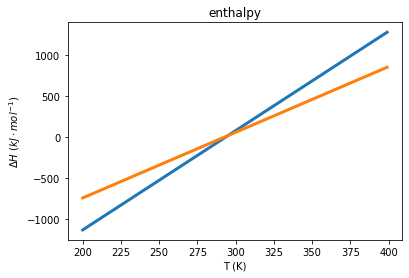

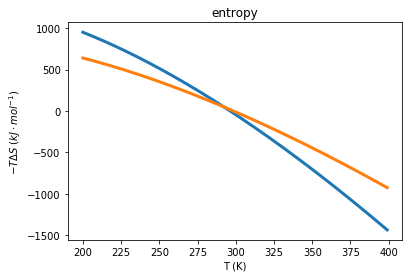

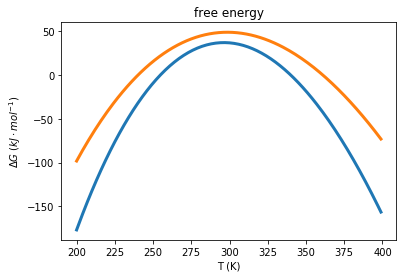

In [88]:
plt.plot(new_T_range,dH_v_T(new_T_range,ec_dCp,ec_dH,ec_Tm),label="dH",linewidth=3)
plt.plot(new_T_range,dH_v_T(new_T_range,tt_dCp,tt_dH,tt_Tm),label="dH",linewidth=3)
plt.title("enthalpy")
plt.xlabel("T (K)")
plt.ylabel("$\Delta H$ ($kJ \cdot mol^{-1}}$)")
plt.show()

plt.plot(new_T_range,-new_T_range*dS_v_T(new_T_range,ec_dCp,ec_dH,ec_Tm),label="-TdS",linewidth=3)
plt.plot(new_T_range,-new_T_range*dS_v_T(new_T_range,tt_dCp,tt_dH,tt_Tm),label="-TdS",linewidth=3)
plt.title("entropy")
plt.xlabel("T (K)")
plt.ylabel("$-T\Delta S$ ($kJ \cdot mol^{-1}}$)")
plt.show()

plt.plot(new_T_range,dG_v_T(new_T_range,ec_dCp,ec_dH,ec_Tm),label="dG",linewidth=3)
plt.plot(new_T_range,dG_v_T(new_T_range,tt_dCp,tt_dH,tt_Tm),label="dG",linewidth=3)

plt.title("free energy")
plt.xlabel("T (K)")
plt.ylabel("$\Delta G$ ($kJ \cdot mol^{-1}}$)")
plt.show()